In [ ]:
!gdown 1fzd8TBUABO0ZE-waTwehJoSoMP2QPa5R
!gdown 1VSDBHZFiv53oCcxfj9UCewZNok9JYxG-
!gdown 115Ja6JBapEAcpdaCkWDXPlXb27B9MiOa

Downloading...
From: https://drive.google.com/uc?id=1fzd8TBUABO0ZE-waTwehJoSoMP2QPa5R
To: /content/transactions.csv
100% 288M/288M [00:01<00:00, 154MB/s]
Downloading...
From: https://drive.google.com/uc?id=1VSDBHZFiv53oCcxfj9UCewZNok9JYxG-
To: /content/test_final.csv
100% 2.97M/2.97M [00:00<00:00, 101MB/s]
Downloading...
From: https://drive.google.com/uc?id=115Ja6JBapEAcpdaCkWDXPlXb27B9MiOa
To: /content/train_final.csv
100% 26.6M/26.6M [00:00<00:00, 81.6MB/s]


In [ ]:
!gdown 1bWell8woNkspvlLmBSb7Q8p0C5Pin07y

Downloading...
From: https://drive.google.com/uc?id=1bWell8woNkspvlLmBSb7Q8p0C5Pin07y
To: /content/data_test_real_final (3).csv
100% 4.38M/4.38M [00:00<00:00, 39.5MB/s]


In [ ]:
from google.colab import files
files.download('test_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install xgboost

In [ ]:
!pip install joblib

Index(['client_id', '1711_negative_transactionsmax',
       '1711_negative_transactionsmedian', '1711_negative_transactionsmin',
       '1711_positive_transactionsmax', '1711_positive_transactionsmedian',
       '1711_positive_transactionsmin', '1731_negative_transactionsmax',
       '1731_negative_transactionsmedian', '1731_negative_transactionsmin',
       ...
       '9311_positive_transactionscount', '9311_positive_transactionssum',
       '9399_negative_transactionscount', '9399_negative_transactionssum',
       '9399_positive_transactionscount', '9399_positive_transactionssum',
       '9402_negative_transactionscount', '9402_negative_transactionssum',
       '9402_positive_transactionscount', '9402_positive_transactionssum'],
      dtype='object', length=1886)

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import joblib

from tqdm._tqdm_notebook import tqdm_notebook

<ipython-input-5-dd84166dfa05>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [ ]:
PATH_DATA = './'
MODEL_PATH = "model.pkl"

In [ ]:
# Считываем данные
tr_mcc_codes = pd.read_csv(os.path.join(PATH_DATA, 'mcc_codes.csv'), sep=';', index_col='mcc_code')
tr_types = pd.read_csv(os.path.join(PATH_DATA, 'trans_types.csv'), sep=';', index_col='trans_type')

transactions = pd.read_csv(os.path.join(PATH_DATA, 'transactions.csv'), index_col='client_id')
gender_train = pd.read_csv(os.path.join(PATH_DATA, 'train.csv'), index_col='client_id')
gender_test = pd.read_csv(os.path.join(PATH_DATA, 'test.csv'), index_col='client_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

In [ ]:
# Функции, которыми можно пользоваться для построения классификатора,
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true),
                  early_stopping_rounds=10, maximize=True,
                  num_boost_round=10000, nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
                                                                        cv_res.loc[index_argmax]['test-auc-std'],
                                                                        index_argmax))

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)),
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])

    joblib.dump(clf, MODEL_PATH)
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки,
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))

    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))

    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

Так как код для оценки модели на тренировочных данных и её применения на тестовых данных уже дан, то мы будем работать над тем, чтобы создать переменные для улучшения результатов моделирования.

<font color='red'><b>!!!</b></font> В рамках данного задания Вы можете делать всё, что угодно - использовать другие алгоритмы и/или их комбинации, подбирать гиперпараметры своих моделей, отбирать переменые, etc. Мы создали шаблон для простоты и для Вашего понимания верхнеуровневого процесса разработки модели, опустив при этом большое число деталей.

## Basic features
Начнём с того, что сформируем базовые переменные по каждому пользователю. На этом этапе будем использовать стандартные агрегации, посчитанные на расходах и приходах клиента:
- минимум
- максимум
- среднее
- медиана
- среднеквадратичное отклонение
- количество

Также параметры модели выберем стандартные, запишем их в словарь params, и будем использовать для дальнейшего построения модели (не забывайте, что с этим Вы можете тоже экспериментировать).

In [ ]:
params = {
    'eta': 0.1,
    'max_depth': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,

    'gamma': 0,
    'lambda': 0,
    'alpha': 0,
    'min_child_weight': 0,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    'njobs': -1,
    'tree_method': 'approx'
}

In [ ]:
for df in [transactions_train, transactions_test]:
    df['num_day'] = df['trans_time'].apply(lambda x: int(x.split(' ')[0]))
    df['datetime'] = df['trans_time'].apply(lambda x: x.split(' ')[1])
    df['hour'] = df['datetime'].apply(lambda x: int(x.split(':')[0]))
    df['minute'] = df['datetime'].apply(lambda x: int(x.split(':')[1]))
    df['second'] = df['datetime'].apply(lambda x: int(x.split(':')[2]))
    df['day'] = df['trans_time'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['trans_time'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

In [ ]:
transactions_train['trans_type'] = transactions_train['trans_type'] + 10000
transactions_test['trans_type'] = transactions_test['trans_type'] + 10000

In [ ]:
def features_creation_advanced(x):
    features = []
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))

    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                       .add_prefix('negative_transactions_')))


    tmp_codes = transactions_train['mcc_code'].unique()
    for code in tmp_codes:
        features.append(pd.Series(x[(x['amount']>0) & (x['mcc_code']==code)]['amount'].agg(['min','max','median','sum','count']).add_prefix(f'{code}_positive_transactions_')))
        features.append(pd.Series(x[(x['amount']<0) & (x['mcc_code']==code)]['amount'].agg(['min','max','median','sum','count']).add_prefix(f'{code}_negative_transactions_')))


    # trans_codes = transactions_train['trans_type'].unique()
    # for code in trans_codes:
    #     features.append(pd.Series(x[(x['amount']>0) & (x['trans_type']==code)]['amount'].agg(['min','max','median','sum','count']).add_prefix(f'{code}_positive_transactions_')))
    #     features.append(pd.Series(x[(x['amount']<0) & (x['trans_type']==code)]['amount'].agg(['min','max','median','sum','count']).add_prefix(f'{code}_negative_transactions_')))

    features.append(pd.Series(x[x['amount'] < 0]['minute'].apply(lambda x: 1 if (x==0 or x==59) else 0).agg(['mean'])).add_prefix('minute_negative_transactrions_'))
    features.append(pd.Series(x[x['amount'] < 0]['hour'].apply(lambda x: 1 if (x==0 or x==23)  else 0).agg(['mean'])).add_prefix('hour_negative_transactrions_'))

    return pd.concat(features)

In [ ]:
tqdm_notebook.pandas(desc="Progress")

data_train = transactions_train.groupby('client_id')\
                               .progress_apply(features_creation_advanced)
data_test = transactions_test.groupby('client_id')\
                             .progress_apply(features_creation_advanced)

Progress:   0%|          | 0/7446 [00:00<?, ?it/s]

Progress:   0%|          | 0/829 [00:00<?, ?it/s]

In [ ]:
data_train.to_csv('data_train_real_final.csv')
data_test.to_csv('data_test_real_final.csv')

In [ ]:
from google.colab import files
files.download('data_train_real_final.csv')
files.download('data_test_real_final.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
target = super_final_train.join(gender_train, how='inner')['gender']
cv_score(params, super_final_train,target)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:18:16] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:18:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:18:18] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:18:19] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.

  warnings.warn(smsg, UserWarning)


Cross-validation, ROC AUC: 0.875+-0.005, Trees: 197


In [ ]:
train_final = pd.read_csv('train_final.csv', index_col='client_id')
test_final = pd.read_csv('test_final.csv', index_col='client_id')

In [ ]:
super_final_train = pd.concat([data_train,train_final], axis=1)
super_final_test = pd.concat([data_test,test_final], axis=1)

In [ ]:
super_final_train

In [ ]:
tmp = pd.read_csv('data_train_real_final.csv', index_col='client_id')

In [ ]:
super_final_train

,12370.0_positive_transactions_min,12370.0_positive_transactions_max,12370.0_positive_transactions_median,12370.0_positive_transactions_sum,12370.0_positive_transactions_count,12370.0_negative_transactions_min,12370.0_negative_transactions_max,12370.0_negative_transactions_median,12370.0_negative_transactions_sum,12370.0_negative_transactions_count,...,9311_positive_transactionscount,9311_positive_transactionssum,9399_negative_transactionscount,9399_negative_transactionssum,9399_positive_transactionscount,9399_positive_transactionssum,9402_negative_transactionscount,9402_negative_transactionssum,9402_positive_transactionscount,9402_positive_transactionssum
client_id,,,,,,,,,,,,,,,,,,,,,
0002cf30347684df542e1a931f356875,NaN,NaN,NaN,0.0,0.0,-2170.07,-2170.07,-2170.070,-2170.07,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0002f4661e0d4d2ae097d78552dad022,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00081e0eca8ad94e493691f8f00099c6,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0019bebcb5435df3103a5b0b52f5fc6b,NaN,NaN,NaN,0.0,0.0,-20246.83,-17.49,-578.445,-33292.07,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
001c8191ecac499718b33dc293a99e5b,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.00,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f8abb882afa8224ee00d196dff235725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fb91d98e9d9b5ad24acab09f0de394e5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fbf60022d446f4d55e3433ab85ef7683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# super_final_train.to_csv('data_train_real_final.csv')
super_final_test.to_csv('data_test_real_final.csv')

In [ ]:
# Число деревьев для XGBoost имеет смысл выятавлять по результатам на кросс-валидации
clf, submission = fit_predict(params, 180, data_train[data_train.columns.intersection(data_test.columns)], data_test, target)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[14:46:30] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "njobs" } are not used.




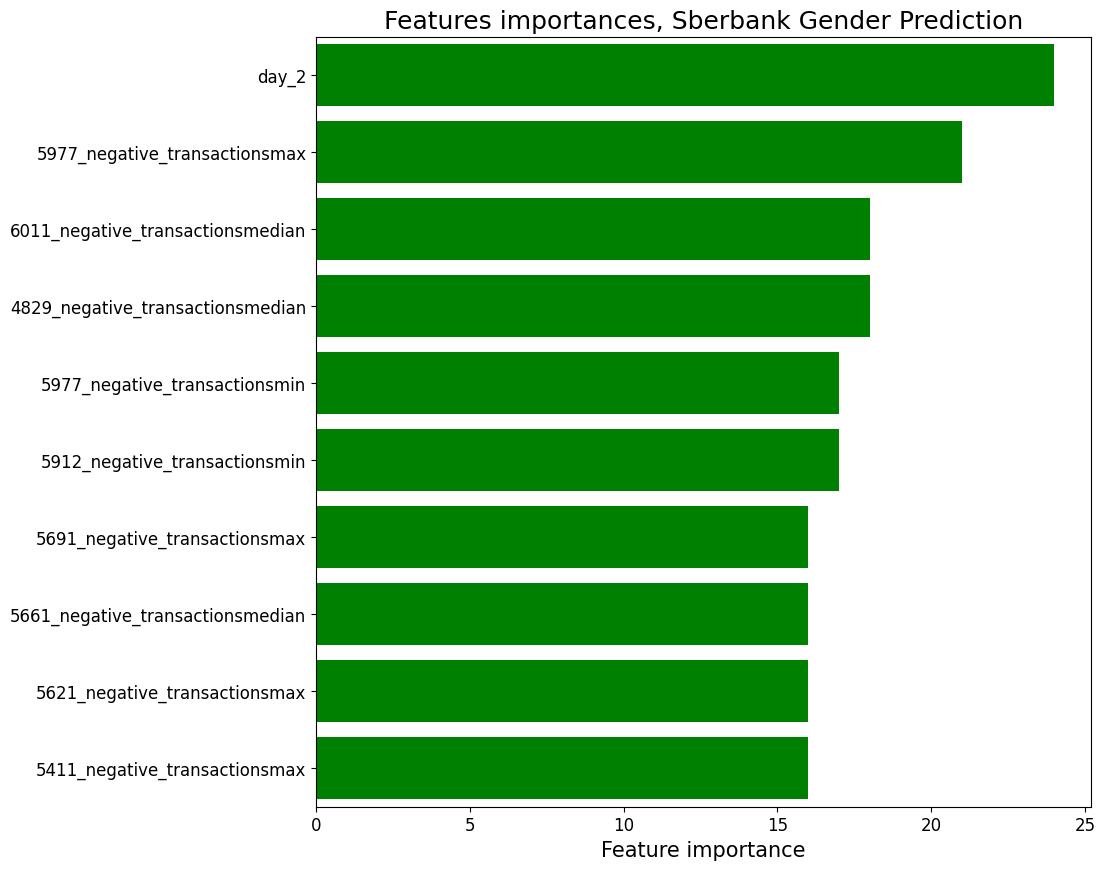

In [ ]:
draw_feature_importances(clf, 10)

<font size=3>Добавление новых переменных улучшило наши результаты ROC AUC с <b>62.2%</b> до <font color='red'><b>68.4%</b></font>, на тестовой выборке результат будет аналогичным, так что мы явно не переобучились. При этом есть куда стремиться!

In [ ]:
# Сохраняем результат моделирования

submission.to_csv('advanced_features_submission.csv')

In [ ]:
!pip freeze

In [ ]:
tqdm_notebook.pandas(desc="Progress")

def features_creation_basic(x):
    features = []
    # features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
    #                                                     .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    features.append(pd.Series(x[x['amount'] < 0]['minute'].apply(lambda x: 1 if (x==0 or x==59) else 0).agg(['mean'])).add_prefix('minute_negative_transactrions_'))
    features.append(pd.Series(x[x['amount'] < 0]['hour'].apply(lambda x: 1 if (x==0 or x==23)  else 0).agg(['mean'])).add_prefix('hour_negative_transactrions_'))

    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index).progress_apply(features_creation_basic)
data_test = transactions_test.groupby(transactions_test.index).progress_apply(features_creation_basic)